# Medical Insurance Cost Prediction

## About Dataset
**Context**\
This dataset includes information on medical costs incurred by individuals and billed to health insurance in the United States.

**Problem definition**\
Identify which factors are highly correlated to the medical cost and train a model to accurately predict it.

**Content**
- `age`: age of primary beneficiary
- `sex`: insurance contractor gender (female, male)
- `bmi`: body mass index, providing an understanding of body, ideally 18.5 to 24.9
- `children`: number of children covered by health insurance / number of dependents
- `smoker`: smoking (true, false)
- `region`: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)
- `charges`: individual medical costs billed by health insurance

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, normalize
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

In [2]:
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\andre\.cache\kagglehub\datasets\mirichoi0218\insurance\versions\1


In [3]:
df = pd.read_csv(path + '/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


### Exploratory Data Analysis

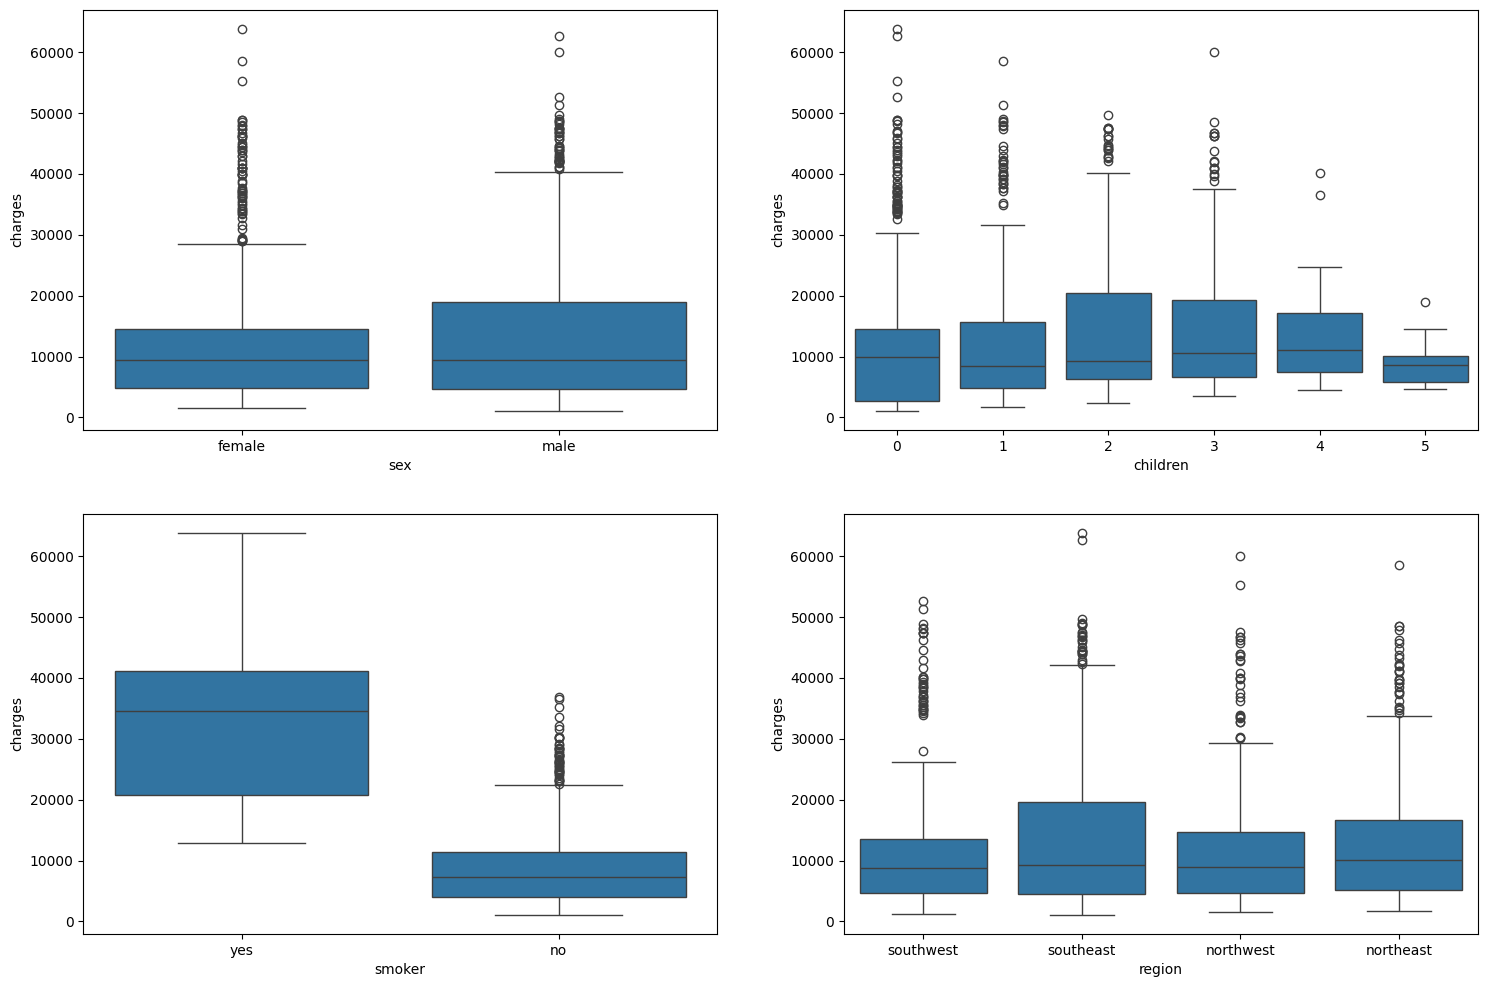

In [6]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.boxplot(x='sex', y='charges', data=df)
plt.subplot(2,2,2)
sns.boxplot(x='children', y='charges', data=df)
plt.subplot(2,2,3)
sns.boxplot(x='smoker', y='charges', data=df)
plt.subplot(2,2,4)
sns.boxplot(x='region', y='charges', data=df)
plt.show()

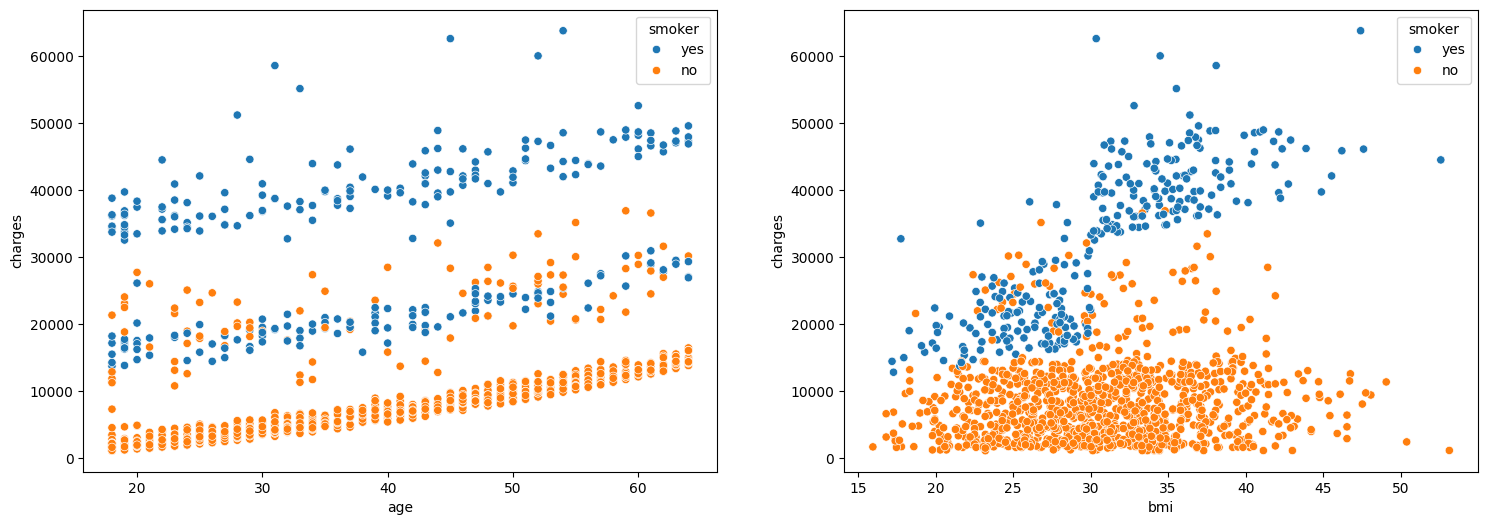

In [7]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')
plt.subplot(1,2,2)
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')
plt.show()

In [8]:
df['sex_encoded'] = df['sex'].map({'female': 1, 'male': 0})
df['smoker_encoded'] = df['smoker'].map({'yes': 1, 'no': 0})

df = df.drop(['sex','smoker'], axis=1)

In [9]:
df_encoded = pd.get_dummies(df, columns=['region'], drop_first=True)
df_encoded.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,1,False,False,True
1,18,33.770,1,1725.55230,0,0,False,True,False
2,28,33.000,3,4449.46200,0,0,False,True,False
3,33,22.705,0,21984.47061,0,0,True,False,False
4,32,28.880,0,3866.85520,0,0,True,False,False


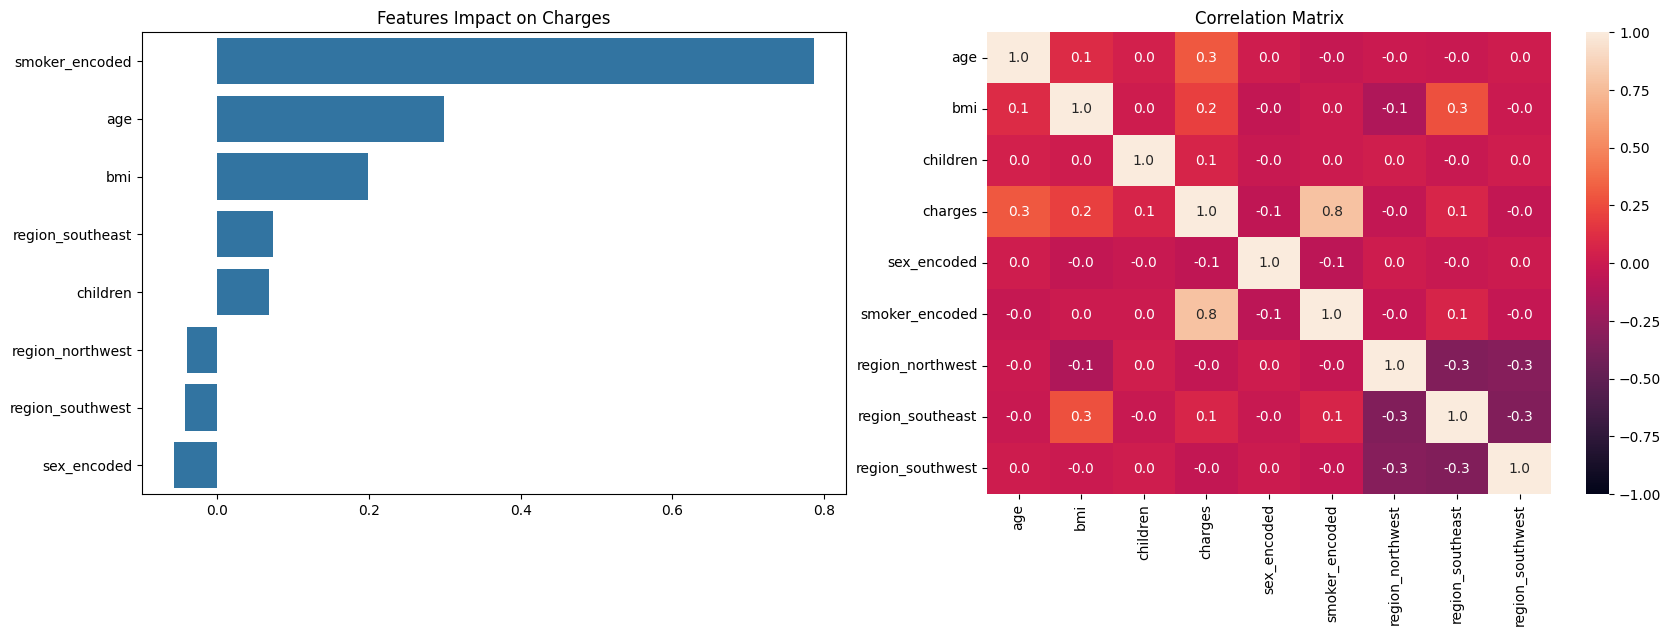

In [10]:
corr = df_encoded.corr()['charges'].drop('charges', axis=0).reset_index().sort_values(by='charges', ascending=False)
corr_matrix = df_encoded.corr()

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.barplot(data=corr, x='charges', y='index')
plt.title('Features Impact on Charges')
plt.xlabel('')
plt.ylabel('')
plt.subplot(1,2,2)
sns.heatmap(corr_matrix, annot=True, fmt='.1f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [11]:
X = df_encoded[['smoker_encoded']]
y = df_encoded.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Models Training

1. Simple Linear Regression

In [12]:
slm = LinearRegression()

slm.fit(X_train, y_train)

LinearRegression()

In [13]:
y_train_pred = slm.predict(X_train)
y_test_pred = slm.predict(X_test)

print('R^2 score for Simple Linear Regression:')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Simple Linear Regression:
on training set: 0.61
on test set: 0.66


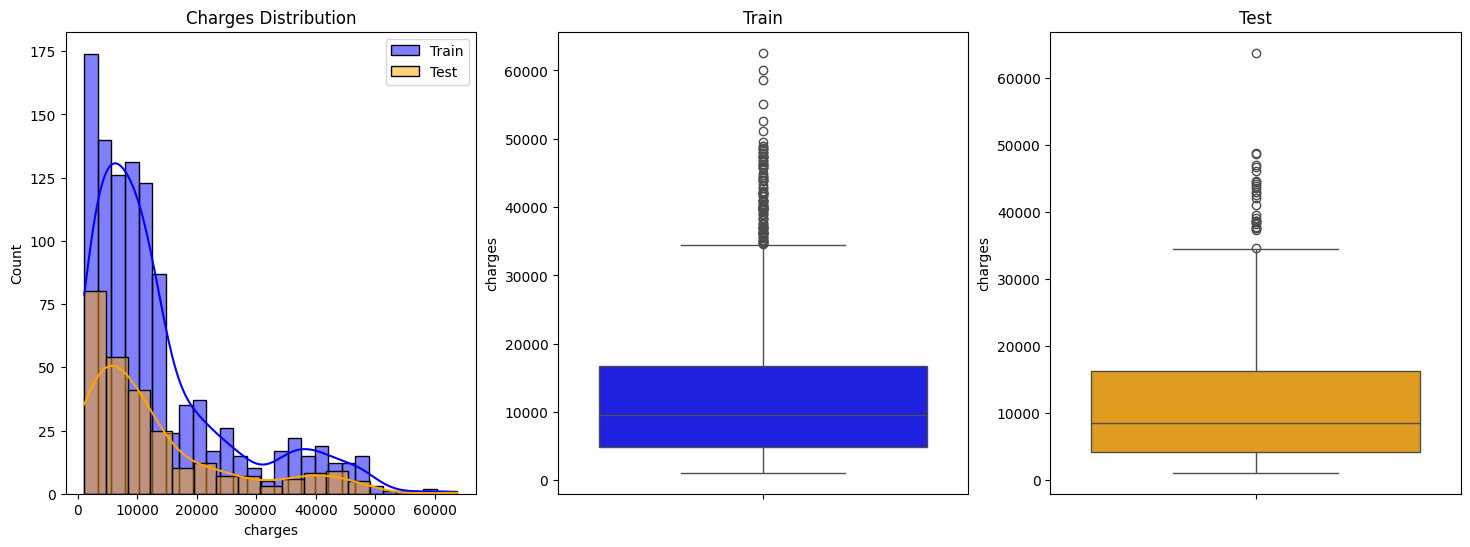

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.histplot(y_train, color='blue', kde=True, label='Train')
sns.histplot(y_test, color='orange', kde=True, label='Test')
plt.title('Charges Distribution')
plt.legend()
plt.subplot(1,3,2)
sns.boxplot(y_train, color='blue')
plt.title('Train')
plt.subplot(1,3,3)
sns.boxplot(y_test, color='orange')
plt.title('Test')
plt.show()

The precence of fewer outliers in the test set can explain why the model performs a little better on unseen data.

2. Multiple Linear Regression

In [15]:
X = df_encoded.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
mlm = LinearRegression()

mlm.fit(X_train, y_train)

LinearRegression()

In [17]:
y_train_pred = mlm.predict(X_train)
y_test_pred = mlm.predict(X_test)

print('R^2 score for Multiple Linear Regression:')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Multiple Linear Regression:
on training set: 0.74
on test set: 0.78


In [18]:
coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': mlm.coef_})
coef.sort_values(by='Coefficient', ascending=False, ignore_index=True)

,Feature,Coefficient
0,smoker_encoded,23651.128856
1,children,425.278784
2,bmi,337.092552
3,age,256.975706
4,sex_encoded,18.591692
5,region_northwest,-370.677326
6,region_southeast,-657.864297
7,region_southwest,-809.799354


In [19]:
print('Intercept:', mlm.intercept_)

Intercept: -11949.810741967724


The negative intercept is due to unscaled data.

3. Polynomial Regression

In [20]:
poly = PolynomialFeatures(degree=2)

X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
pm = LinearRegression()

pm.fit(X_train, y_train)

LinearRegression()

In [22]:
y_train_pred = pm.predict(X_train)
y_test_pred = pm.predict(X_test)

print('R^2 score for Polinomial Regression (degree 2):')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Polinomial Regression (degree 2):
on training set: 0.84
on test set: 0.87


3. Ridge and Lasso Regression with Hyperparameters Tuning

In [23]:
X = df_encoded.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

param_grid = [
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 100.0],
        'regressor__solver': ['auto', 'svd', 'cholesky']
    },
    {
        'regressor': [Lasso()],
        'regressor__alpha': [1.0, 10.0, 100.0],
        'regressor__max_iter': [1000, 5000]
    }
]

In [24]:
cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Ridge())]),
             param_grid=[{'regressor': [Ridge()],
                          'regressor__alpha': [0.1, 1.0, 100.0],
                          'regressor__solver': ['auto', 'svd', 'cholesky']},
                         {'regressor': [Lasso()],
                          'regressor__alpha': [1.0, 10.0, 100.0],
                          'regressor__max_iter': [1000, 5000]}],
             scoring='r2')

In [25]:
print('Best parameters:', cv.best_params_)
print('Best cv score: %.2f' % cv.best_score_)

Best parameters: {'regressor': Lasso(), 'regressor__alpha': 100.0, 'regressor__max_iter': 1000}
Best cv score: 0.73


In [26]:
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

print('R^2 score for Lasso Regression (alpha=100, max_iter=1000):')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Lasso Regression (alpha=100, max_iter=1000):
on training set: 0.74
on test set: 0.78


In [27]:
features = X.columns
coefficients = cv.best_estimator_.named_steps['regressor'].coef_

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

selected = coef_df[coef_df['Coefficient'] != 0]

print("Selected features (non-zero coefficients):")
selected.sort_values(by='Coefficient', key=abs, ascending=False, ignore_index=True)

Selected features (non-zero coefficients):


,Feature,Coefficient
0,smoker_encoded,9453.068030
1,age,3528.802468
2,bmi,1892.789994
3,children,424.978753
4,region_southwest,-104.379764
5,region_southeast,-15.589796


In [28]:
print("Intercept:", cv.best_estimator_.named_steps['regressor'].intercept_)

Intercept: 13346.089736364485


4. Decision Tree Regression

In [29]:
df_enc = pd.get_dummies(df, columns=['region'])
df_enc.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,1,False,False,False,True
1,18,33.770,1,1725.55230,0,0,False,False,True,False
2,28,33.000,3,4449.46200,0,0,False,False,True,False
3,33,22.705,0,21984.47061,0,0,False,True,False,False
4,32,28.880,0,3866.85520,0,0,False,True,False,False


In [30]:
y = df_enc.charges
X = df_enc.drop('charges', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
dtm = DecisionTreeRegressor()

dtm.fit(X_train, y_train)

DecisionTreeRegressor()

In [32]:
y_train_pred = dtm.predict(X_train)
y_test_pred = dtm.predict(X_test)

print('R^2 score for Decision Tree Regression:')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Decision Tree Regression:
on training set: 1.00
on test set: 0.75


No stopping criteria was set, so the tree perfectly memorized the training data (overfitting).

In [33]:
tree = DecisionTreeRegressor(max_depth=4, random_state=42)

tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [34]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('R^2 score for Decision Tree Regression (max_depth=4):')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Decision Tree Regression (max_depth=4):
on training set: 0.87
on test set: 0.86


5. Decision Tree Regression with Hyperparameters Tuning

In [35]:
dec_tree = DecisionTreeRegressor(random_state=42)

params = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20]}

In [36]:
cv = GridSearchCV(dec_tree, params, cv=5)

cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20, 50]})

In [37]:
print('Best parameters:', cv.best_params_)
print('Best cv score: %.2f' % cv.best_score_)

Best parameters: {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best cv score: 0.84


In [38]:
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

print('R^2 score for Decision Tree Regression (max_depth=7, min_samples_leaf=20, min_samples_split=2):')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for Decision Tree Regression (max_depth=7, min_samples_leaf=20, min_samples_split=2):
on training set: 0.88
on test set: 0.87


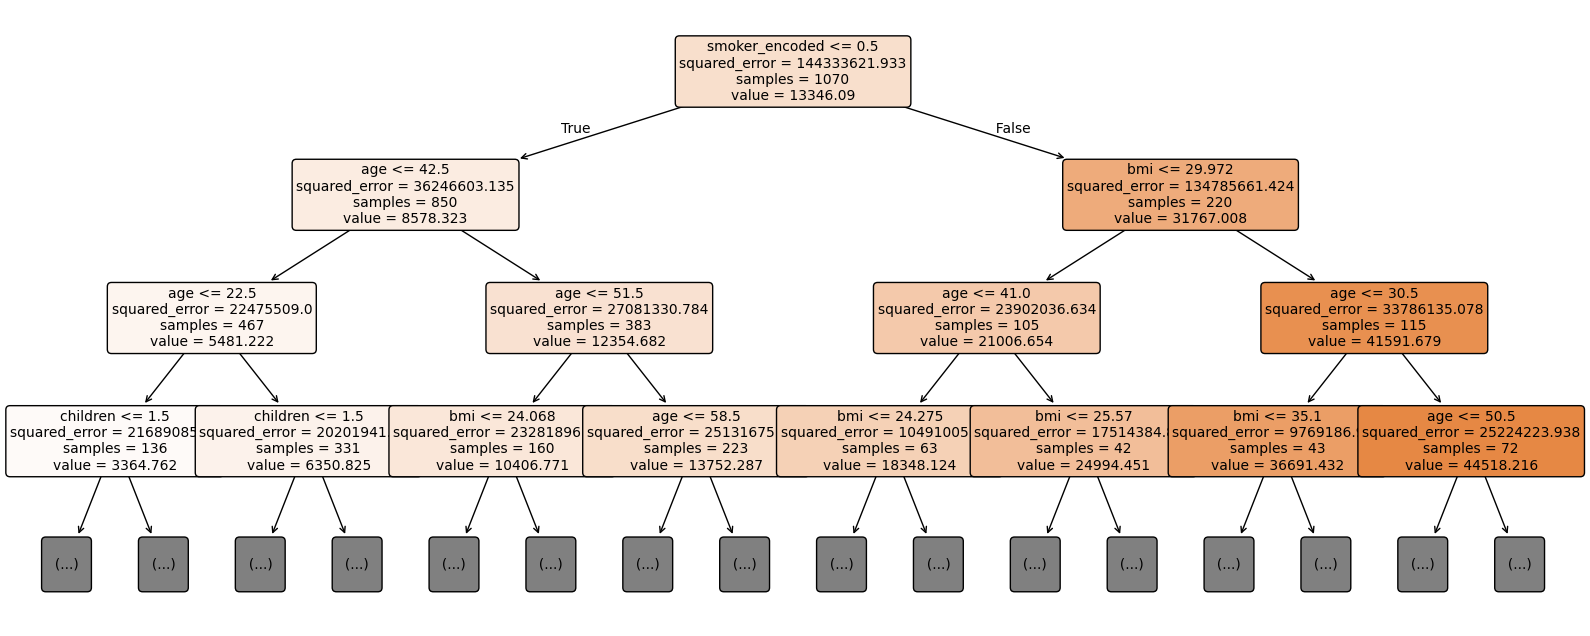

In [39]:
plt.figure(figsize=(20,8))
plot_tree(
    cv.best_estimator_, 
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.show()

6. Random Forest and XGB Regression with Hyperparameters Tuning

In [40]:
pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

param_grid = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [4, 8, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 5],
        'regressor__max_features': ['sqrt', 'log2']
    },
    {
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__subsample': [0.8, 1.0],
        'regressor__colsample_bytree': [0.8, 1.0],
        'regressor__min_child_weight': [1, 3]

    }
]

In [41]:
cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [4, 8, 10],
                          'regressor__max_features': ['sqrt', 'log2'],
                          'regressor__min_samples_leaf': [1, 2, 5],
                          'regressor__min_samples_split': [2, 5, 10],
                          'regressor__n_estimators': [100, 200]},
                         {'regressor': [XG...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...)],
                          'regressor__colsample_bytree': [0.8, 1.0],
                          'regressor__learning_rate': [0.05, 0.1],
                          'regressor__max_depth': [3, 5, 7],
                          'regressor__min_child_weight': [1, 3],
                          'regressor__n_estimators': [100, 200],
                          'regressor__subsample': [0.8, 1.0]}],
             scoring='r2')

In [42]:
best_params = cv.best_params_

best_model = cv.best_estimator_.named_steps['regressor']

model_specific_params = {
    key.replace('regressor__', ''): value
    for key, value in best_params.items()
    if key.startswith('regressor__')
}

print('Best parameters:', model_specific_params)
print('Best cv score: %.2f' % cv.best_score_)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best cv score: 0.85


In [43]:
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

print('R^2 score for XGB Regression:')
print('on training set: %.2f' % r2_score(y_train, y_train_pred))
print('on test set: %.2f' % r2_score(y_test, y_test_pred))

R^2 score for XGB Regression:
on training set: 0.88
on test set: 0.88


<Figure size 600x400 with 0 Axes>

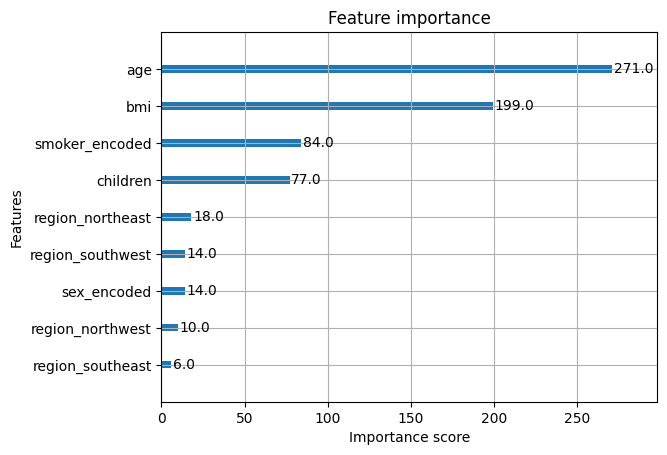

In [44]:
plt.figure(figsize=(6,4))
plot_importance(best_model)
plt.show()

In [45]:
print('Other metrics for XGB Regression (best model):')
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_test_pred)))

Other metrics for XGB Regression (best model):
Mean Absolute Error: 2338.59
Mean Squared Error: 18276255.26
Root Mean Squared Error: 4275.07


In [46]:
y.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

The model's average prediction error is 2338.59, which is about 17.6% of the mean medical charge (≈13270).
With an R² score of 0.88, this indicates the model explains most of the variance and performs well overall.